## Setup

In [1]:
import numpy as np
from IPython.display import clear_output
import pandas as pd
import os
import typing
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load the MHealth Dataset

In [14]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00319/MHEALTHDATASET.zip
!unzip MHEALTHDATASET.zip
clear_output()
mhealth_dataset = []
for path, dir, file in os.walk("/content/MHEALTHDATASET"):
    for fileNames in file:
        if fileNames.endswith("log"):
            fileName = str(os.path.join(path,fileNames))
            tmpData = pd.read_csv(fileName, sep='\t', engine='python')
            np.shape(tmpData.to_numpy()) # time x variables
            mhealth_dataset.append(tmpData.to_numpy())

tcat = []
for i in range(len(mhealth_dataset)):
  # Truncate all time series to the same length
  t = torch.from_numpy(mhealth_dataset[i][:98303,:])
  tcat.append(t)
tcat = torch.stack(tcat, dim=0)
tcat.size() # subjects x time x var
mhealth = tcat.numpy()
print("Raw 3D time series shape: {0}".format(mhealth.shape))
mhealth_reshaped = np.transpose(mhealth, (1, 0, 2))
print("New 3D time series shape: {0}".format(mhealth_reshaped.shape))

# Downsample the data
mhealth_reshaped_ds = mhealth_reshaped[::5]
print("Downsampled 3D time series shape: {0}".format(mhealth_reshaped_ds.shape))

# Truncate the dataset
nsubjects = 1
features_to_keep = [1,2,5,6,9]
truncated_mhealth = mhealth_reshaped_ds[:, :nsubjects, features_to_keep]
print("Truncated time series shape: {0}".format(truncated_mhealth.shape)) # timesteps x features

# We can only predict 1 feature at a time
# Let's choose 1 subject and see if we can predict 1 feature from other features
truncated_mhealth1 = np.squeeze(truncated_mhealth[:,0,:])
print("Final data array shape: {0}".format(truncated_mhealth1.shape))

Raw 3D time series shape: (10, 98303, 24)
New 3D time series shape: (98303, 10, 24)
Downsampled 3D time series shape: (19661, 10, 24)
Truncated time series shape: (19661, 1, 5)
Final data array shape: (19661, 5)


## Load the MSense Dataset

In [5]:
%cd /content/
!git clone https://github.com/mmalekzadeh/motion-sense
!unzip /content/motion-sense/data/A_DeviceMotion_data.zip
!unzip /content/motion-sense/data/B_Accelerometer_data.zip
!unzip /content/motion-sense/data/C_Gyroscope_data.zip
clear_output()

In [10]:
sub_ids = [10]

def get_ds_infos():
    """ Gets inforamtion about data subjects' attributes""" 
    dss = pd.read_csv("/content/motion-sense/data/data_subjects_info.csv")
    return dss

def set_data_types(data_types=["userAcceleration"]):
    """ Select the sensors and the mode to shape the final dataset. """
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])
    return dt_list

def creat_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=False):
    """ It returns a time-series of sensor data. """
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0, num_data_cols+7)) # "7" --> [act, code, weight, height, age, gender, trial] 
    else:
        dataset = np.zeros((0, num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in sub_ids:
        for act_id, act in enumerate(act_labels): # for each activity
            for trial in trial_codes[act_id]: # for each variable
                fname = 'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id,
                            sub_id-1,
                            ds_list["weight"][sub_id-1],
                            ds_list["height"][sub_id-1],
                            ds_list["age"][sub_id-1],
                            ds_list["gender"][sub_id-1],
                            trial          
                           ]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset, vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act", "id", "weight", "height", "age", "gender", "trial"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset

ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

# Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
# attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["userAcceleration",'gravity','rotationRate']
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS[2:4]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = creat_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))  

[INFO] -- Selected sensor data types: ['userAcceleration', 'gravity', 'rotationRate']
[INFO] -- Selected activites: ['wlk', 'jog']
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(20620, 16)


In [15]:
truncated_msense = []
features_to_keep = [1,2,3,4,6]
for sub_id in [9]:
  sub_dataset = dataset[dataset["id"].isin([float(sub_id)])]
  sub_tensor = torch.tensor(sub_dataset.values)
  sub_tensor = sub_tensor[0:18836, features_to_keep]
  sub_tensor_numpy = sub_tensor.numpy()
  truncated_msense.append(sub_tensor_numpy)
  
truncated_msense = np.squeeze(np.stack(truncated_msense, axis=1))
print("Final Msense data shape:" + str(truncated_msense.shape)) # timesteps x features

Final Msense data shape:(18836, 5)


## Format datasets for Keras

In [16]:
train_size, val_size = 0.6, 0.2

def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array


In [18]:
# Create train and test arrays for both datasets

mh_train_array, mh_val_array, mh_test_array = preprocess(truncated_mhealth1, train_size, val_size)
print(f"mhealth train set size: {mh_train_array.shape}")
print(f"mhealth validation set size: {mh_val_array.shape}")
print(f"mhealth test set size: {mh_test_array.shape}")

ms_train_array, ms_val_array, ms_test_array = preprocess(truncated_msense, train_size, val_size)
print(f"msense train set size: {ms_train_array.shape}")
print(f"msense validation set size: {ms_val_array.shape}")
print(f"msense test set size: {ms_test_array.shape}")

mhealth train set size: (11796, 5)
mhealth validation set size: (3932, 5)
mhealth test set size: (3933, 5)
msense train set size: (11301, 5)
msense validation set size: (3767, 5)
msense test set size: (3768, 5)


In [21]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

batch_size = 64
input_sequence_length = 50
forecast_horizon = 50
multi_horizon = True

def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 64,
    shuffle = True,
    multi_horizon = True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor of shape `(batch_size, input_sequence_length, num_routes, 1 num_features)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """
    inputs = timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()

In [22]:
# Format datasets for keras

mh_train_dataset, mh_val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [mh_train_array, mh_val_array]
)

mh_test_dataset = create_tf_dataset(mh_test_array, input_sequence_length,
    forecast_horizon, batch_size = mh_test_array.shape[0],
    shuffle = False, multi_horizon = multi_horizon)

ms_train_dataset, ms_val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [ms_train_array, ms_val_array]
)

ms_test_dataset = create_tf_dataset(ms_test_array, input_sequence_length,
    forecast_horizon, batch_size = ms_test_array.shape[0],
    shuffle = False, multi_horizon = multi_horizon)

In [20]:
# Create adjacency matrix
class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes

adj_matrix = np.identity(truncated_mhealth1.shape[1], dtype="float32")
node_indices, neighbor_indices = np.where(adj_matrix == 1)

graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adj_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")

number of nodes: 5, number of edges: 5


## Define the model

In [23]:
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)

In [24]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)
        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)
        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(inputs)  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        print(shape)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3]
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(gcn_out)  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(lstm_out)  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(output, [1, 2, 0])  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)

## Train

In [26]:
in_feat = 1
batch_size = 64
epochs = 20
input_sequence_length = 50
forecast_horizon = 50
multi_horizon = True
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(in_feat, out_feat, lstm_units, input_sequence_length,
                forecast_horizon, graph, graph_conv_params)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(optimizer = keras.optimizers.RMSprop(learning_rate=0.0002),
    loss = keras.losses.MeanSquaredError())

Tensor("lstmgc/Shape:0", shape=(4,), dtype=int32)


### Fit the mhealth dataset

In [27]:
model.fit(mh_train_dataset, validation_data = mh_val_dataset,
    epochs=epochs, callbacks=[keras.callbacks.EarlyStopping(patience=20)])

Epoch 1/20
Tensor("model/lstmgc/Shape:0", shape=(4,), dtype=int32)
Tensor("model/lstmgc/Shape:0", shape=(4,), dtype=int32)
183/183 [==============================] - 35s 175ms/step - loss: 0.9459 - val_loss: 1.2657
Epoch 2/20
183/183 [==============================] - 31s 168ms/step - loss: 0.7759 - val_loss: 1.2506
Epoch 3/20
183/183 [==============================] - 30s 165ms/step - loss: 0.6500 - val_loss: 1.2459
Epoch 4/20
183/183 [==============================] - 31s 168ms/step - loss: 0.5872 - val_loss: 1.2436
Epoch 5/20
183/183 [==============================] - 32s 176ms/step - loss: 0.5498 - val_loss: 1.2418
Epoch 6/20
183/183 [==============================] - 31s 168ms/step - loss: 0.5393 - val_loss: 1.2399
Epoch 7/20
183/183 [==============================] - 31s 169ms/step - loss: 0.5332 - val_loss: 1.2387
Epoch 8/20
183/183 [==============================] - 31s 168ms/step - loss: 0.5300 - val_loss: 1.2375
Epoch 9/20
183/183 [==============================] - 31s 169ms/

120/120 [==============================] - 5s 44ms/step
Naive MAE: 2.1683755162500504, Model MAE: 1.1367520933258362


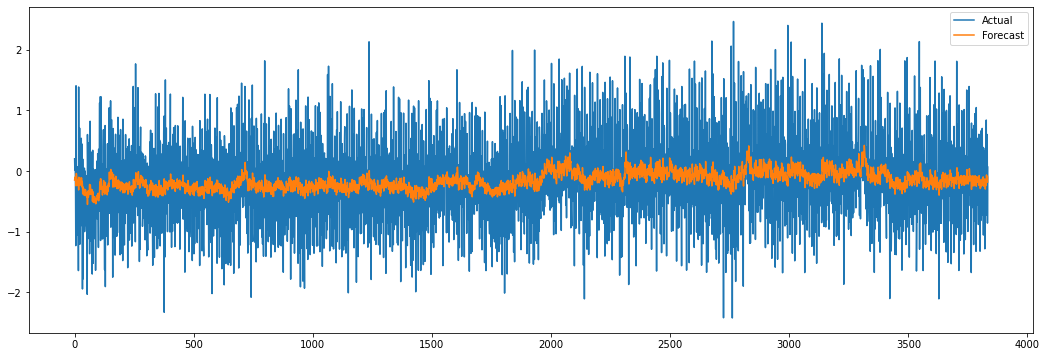

In [30]:
mh_x_test, mh_y = next(mh_test_dataset.as_numpy_iterator())
mh_y_pred = model.predict(mh_x_test)
plt.figure(figsize=(18, 6))
plt.plot(mh_y[:, 0, 0])
plt.plot(mh_y_pred[:, 0, 0])
plt.legend(["Actual", "Forecast"])

naive_mse, model_mse = (
    np.square(mh_x_test[:, -1, :, 0] - mh_y[:, 0, :]).mean(),
    np.square(mh_y_pred[:, 0, :] - mh_y[:, 0, :]).mean(),
)
print(f"Naive MAE: {naive_mse}, Model MAE: {model_mse}")

### Fit the msense dataset

In [31]:
model.fit(ms_train_dataset, validation_data = ms_val_dataset,
    epochs=epochs, callbacks=[keras.callbacks.EarlyStopping(patience=20)])

Epoch 1/20
176/176 [==============================] - 32s 175ms/step - loss: 1.5858 - val_loss: 1.0155
Epoch 2/20
176/176 [==============================] - 30s 170ms/step - loss: 0.7633 - val_loss: 0.9812
Epoch 3/20
176/176 [==============================] - 29s 165ms/step - loss: 0.6941 - val_loss: 0.9381
Epoch 4/20
176/176 [==============================] - 31s 176ms/step - loss: 0.6508 - val_loss: 0.9013
Epoch 5/20
176/176 [==============================] - 30s 172ms/step - loss: 9.2869 - val_loss: 0.8799
Epoch 6/20
176/176 [==============================] - 29s 162ms/step - loss: 13.8608 - val_loss: 0.8785
Epoch 7/20
176/176 [==============================] - 29s 162ms/step - loss: 41.1317 - val_loss: 0.9415
Epoch 8/20
176/176 [==============================] - 33s 186ms/step - loss: 69.0962 - val_loss: 0.8717
Epoch 9/20
176/176 [==============================] - 28s 160ms/step - loss: 14.4181 - val_loss: 0.8679
Epoch 10/20
176/176 [==============================] - 29s 163ms/step

115/115 [==============================] - 4s 33ms/step
Naive MAE: 3.1076254601493813, Model MAE: 2.4319297826273942


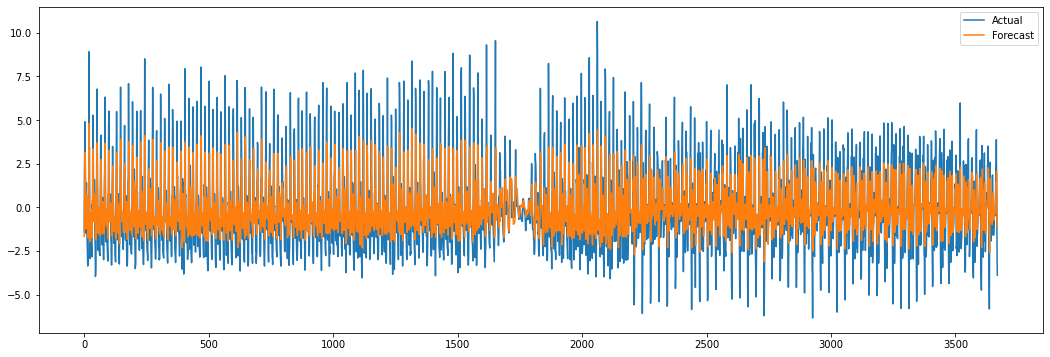

In [32]:
ms_x_test, ms_y = next(ms_test_dataset.as_numpy_iterator())
ms_y_pred = model.predict(ms_x_test)
plt.figure(figsize=(18, 6))
plt.plot(ms_y[:, 0, 0])
plt.plot(ms_y_pred[:, 0, 0])
plt.legend(["Actual", "Forecast"])

naive_mse, model_mse = (
    np.square(ms_x_test[:, -1, :, 0] - ms_y[:, 0, :]).mean(),
    np.square(ms_y_pred[:, 0, :] - ms_y[:, 0, :]).mean(),
)
print(f"Naive MAE: {naive_mse}, Model MAE: {model_mse}")